In [1]:
library(ggplot2)
library(cowplot)

t = theme(plot.title = element_text(size=26, hjust=0.5),
          axis.title = element_text(size=20),
          axis.text = element_text(size=16),
          legend.title = element_text(size = 20),
          legend.text = element_text(size = 16),
          plot.subtitle = element_text(size = 18, face="bold"))
theme_set(theme_minimal()+t)

In [2]:
suppressMessages(library(TSA))
suppressMessages(library(tseries))

# Lag function
suppressMessages(library(Hmisc))

# Forecast (Arima)
suppressMessages(library(forecast))

# GARCH models
suppressMessages(library(rugarch))

# Modelos de Séries Temporais Heteroscedásticos

Neste estudo, faremos um estudo introdutório sobre a classe de modelos heteroscedásticos, proposta inicialmente por Engle (1982) e generalizada por Bollerslev (1987), quanto ao uso de modelos de Séries Temporais condizentes ao comportamento observado em séries associadas ao mercado financeiro.

## Modelo ARCH

Definimos que a série temporal $\boldsymbol{y} = (y_1, \dots, y_N)$ segue o modelo $\text{ARCH}(r)$ quando
\begin{equation*}
    \begin{cases}
        X_t = \sqrt{h_t} \varepsilon_t \text{, } \varepsilon_t \sim N(0,1)\\
        h_t = \alpha_0 + \sum_{i=1}^r \alpha_i X_{t-i}^2
    \end{cases},
\end{equation*}
em que $\alpha_0 > 0$, $\alpha_i$.

## Modelo GARCH

Definimos que a série temporal $\boldsymbol{y} = (y_1, \dots, y_N)$ segue o modelo $\text{GARCH}(r,s)$ quando
\begin{equation*}
    \begin{cases}
        X_t = \sqrt{h_t} \varepsilon_t \text{, } \varepsilon_t \sim N(0,1)\\
        h_t = \alpha_0 + \sum_{i=1}^r \alpha_i X_{t-i}^2 + \sum_{j=1}^s \beta_j h_{t-j}
    \end{cases},
\end{equation*}
em que $\alpha_0 > 0$, $\alpha_i$, $\beta_j > 0$, $\sum_{i=1}^q (\alpha_i + \beta_i) < 1$, onde $q = \max\left\{r, s\right\}$.

(Supondo que $r < q$, por exemplo, consideramos que $\alpha_{r+1} = \cdots = \alpha_q = 0$)

## Proposta do Estudo

Ao longo deste trabalho, será feita uma aplicação do modelo $\text{ARCH}(r)$ aos dados das ações da Petrobras (PETRO-PN no período de 3 de janeiro de 1995 a 27 de dezembro de 2000, com $N=1499$ observações) mencionado no livro "Análise de Séries Temporais" (MORETTIN - 2006), no capítulo 14. Temos o interesse em replicar os resultados originais obtidos pelos autores.

# Dados da PETROBRAS PN

A seguir carregamos e analisamos os valores de fechamento diários das ações da PETROBRAS PN (PETR4) no período de 03/01/1995 até 27/12/2000.

In [3]:
df <- read.csv("PETR4.csv")
head(df, 2)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var.
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,27.12.2000,"4,17","4,15","4,21","4,12","18,85M","1,21%"
2,26.12.2000,"4,12","4,15","4,20","4,12","10,77M","-0,72%"


In [4]:
df <- read.csv("PETR4.csv")

# Rename columns (vol in M and var in %)
colnames(df) <- c("date", "close", "open", "max", "min", "vol", "var")

# Substitute ',' by '.' for numeric values
df <- as.data.frame( apply(df, 2, function(x){ gsub(",", ".", x) }) )
df$vol <- gsub("M", "", df$vol)
df$var <- gsub("%", "", df$var)

df$date <- as.Date(df$date, format = "%d.%m.%Y")
suppressWarnings( df$close <- as.numeric(df$close) )
suppressWarnings( df$open <- as.numeric(df$open) )
suppressWarnings( df$max <- as.numeric(df$max) )
suppressWarnings( df$min <- as.numeric(df$min) )
suppressWarnings( df$vol <- as.numeric(df$vol) )
suppressWarnings( df$var <- as.numeric(df$var) )

df <- df[order(df$date),]
rownames(df) <- 1:nrow(df)

head(df, 2)

,date,close,open,max,min,vol,var
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1995-01-03,0.91,0.98,1.0,0.90,NA,-6.19
2,1995-01-04,0.88,0.90,0.9,0.85,NA,-3.30


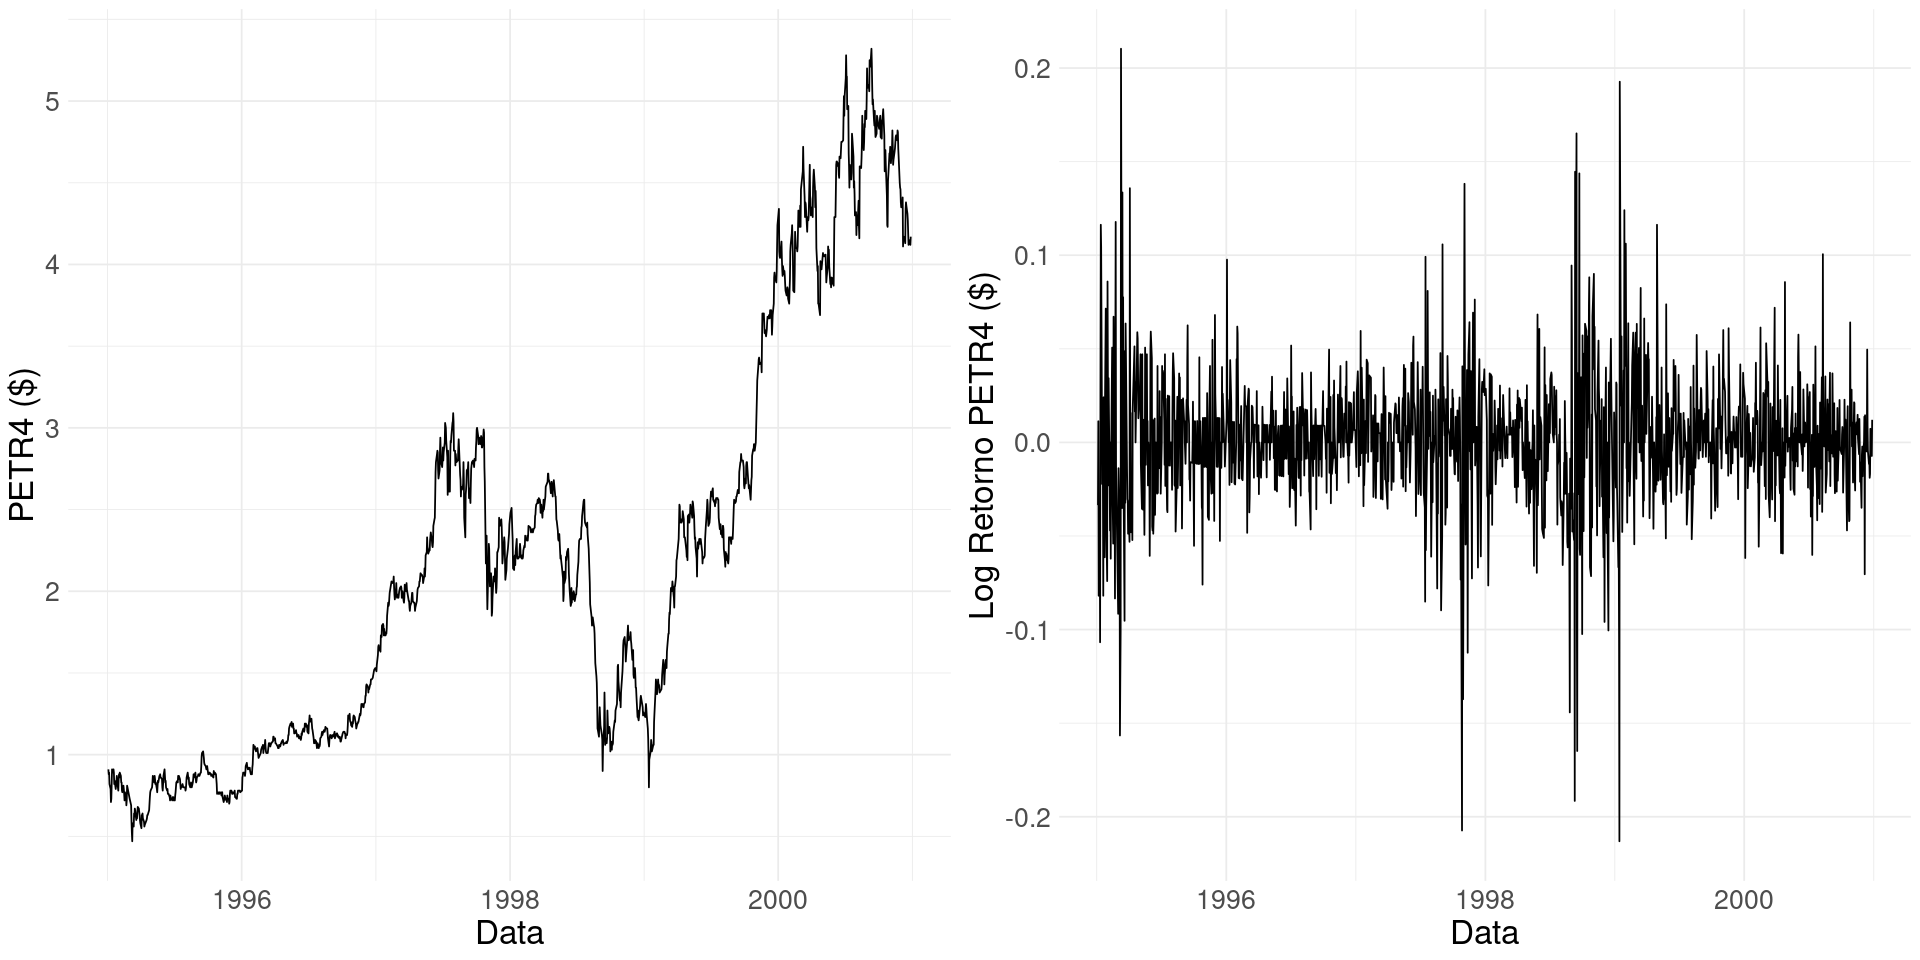

In [5]:
y <- df$close
# Log-returns
z <- log(y / Lag(y))[-1]

# Series size
N <- length(z)
t <- 1:N

g1 <- ggplot()+
    geom_line(aes(x = df$date, y = y))+
    labs(x = "Data", y = "PETR4 ($)")

g2 <- ggplot()+
    geom_line(aes(x = df$date[-1], y = z))+
    labs(x = "Data", y = "Log Retorno PETR4 ($)")

options(repr.plot.width=16, repr.plot.height=8)
plot_grid(g1, g2)

Façamos um breve estudo das autocorrelações e autocorrelações parciais dos dados de forma a obtermos a ordem mais adequada para a aplicação de um modelo ARMA aos dados, removendo assim toda a autocorrelação amostral. Uma vez removida a autocorrelação, estudamos a volatilidade dos dados através dos resíduos do primeiro modelo aplicado.

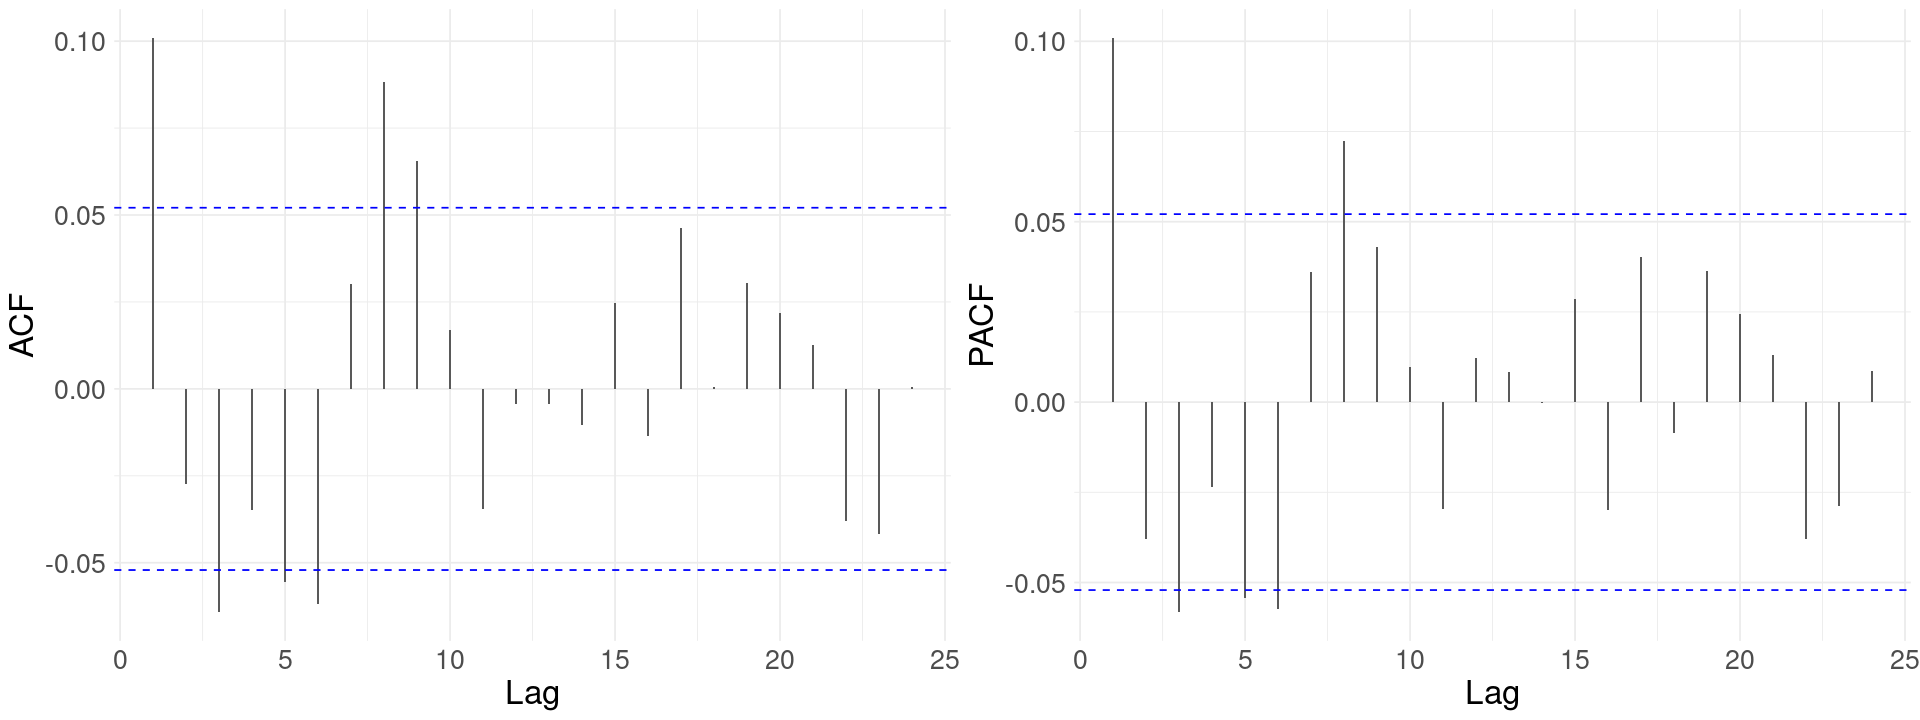

In [6]:
ACF_Z <- acf(z, lag.max = 24, plot = FALSE)
PACF_Z <- pacf(z, lag.max = 24, plot = FALSE)

g1 <- ggplot()+
    geom_col(aes(x = ACF_Z$lag, y = ACF_Z$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "ACF")

g2 <- ggplot()+
    geom_col(aes(x = PACF_Z$lag, y = PACF_Z$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "PACF")

options(repr.plot.width=16, repr.plot.height=6)
plot_grid(g1, g2)

Como podemos observar através das autocorrelações e autocorrelações parciais amostrais, temos indícios de que o último valor de autocorrelação significativo é dado no lag 9. Como sugere Morettin (2006) façamos os testes considerando apenas os modelos AR, desconsiderando, neste caso, a componente MA do modelo ARMA aplicado.

AIC de AR(1): -5745.67464256104 ou -6.73724927981575 (Akaike 1973-1974)
AIC de AR(2): -5744.94942059234 ou -6.73675727033902 (Akaike 1973-1974)
AIC de AR(3): -5753.13108767843 ou -6.74230792643542 (Akaike 1973-1974)
AIC de AR(4): -5751.80085052863 ou -6.74140545889824 (Akaike 1973-1974)
AIC de AR(5): -5763.12136021233 ou -6.74908558758461 (Akaike 1973-1974)
AIC de AR(6): -5765.82164793313 ou -6.7509175331211 (Akaike 1973-1974)
AIC de AR(7): -5773.9026766404 ou -6.75639991351952 (Akaike 1973-1974)
AIC de AR(8): -5785.38579492209 ou -6.76419036011497 (Akaike 1973-1974)
AIC de AR(9): -5786.27574258246 ou -6.76479412379229 (Akaike 1973-1974)
AIC de AR(10): -5784.23481557678 ou -6.7634095057423 (Akaike 1973-1974)
AIC de AR(11): -5782.74805731677 ou -6.76240085020634 (Akaike 1973-1974)
AIC de AR(12): -5783.88882003415 ou -6.76317477335246 (Akaike 1973-1974)
AIC de AR(13): -5783.31372326791 ou -6.76278461272408 (Akaike 1973-1974)
AIC de AR(14): -5784.19240724207 ou -6.76338073482324 (Akaike 1

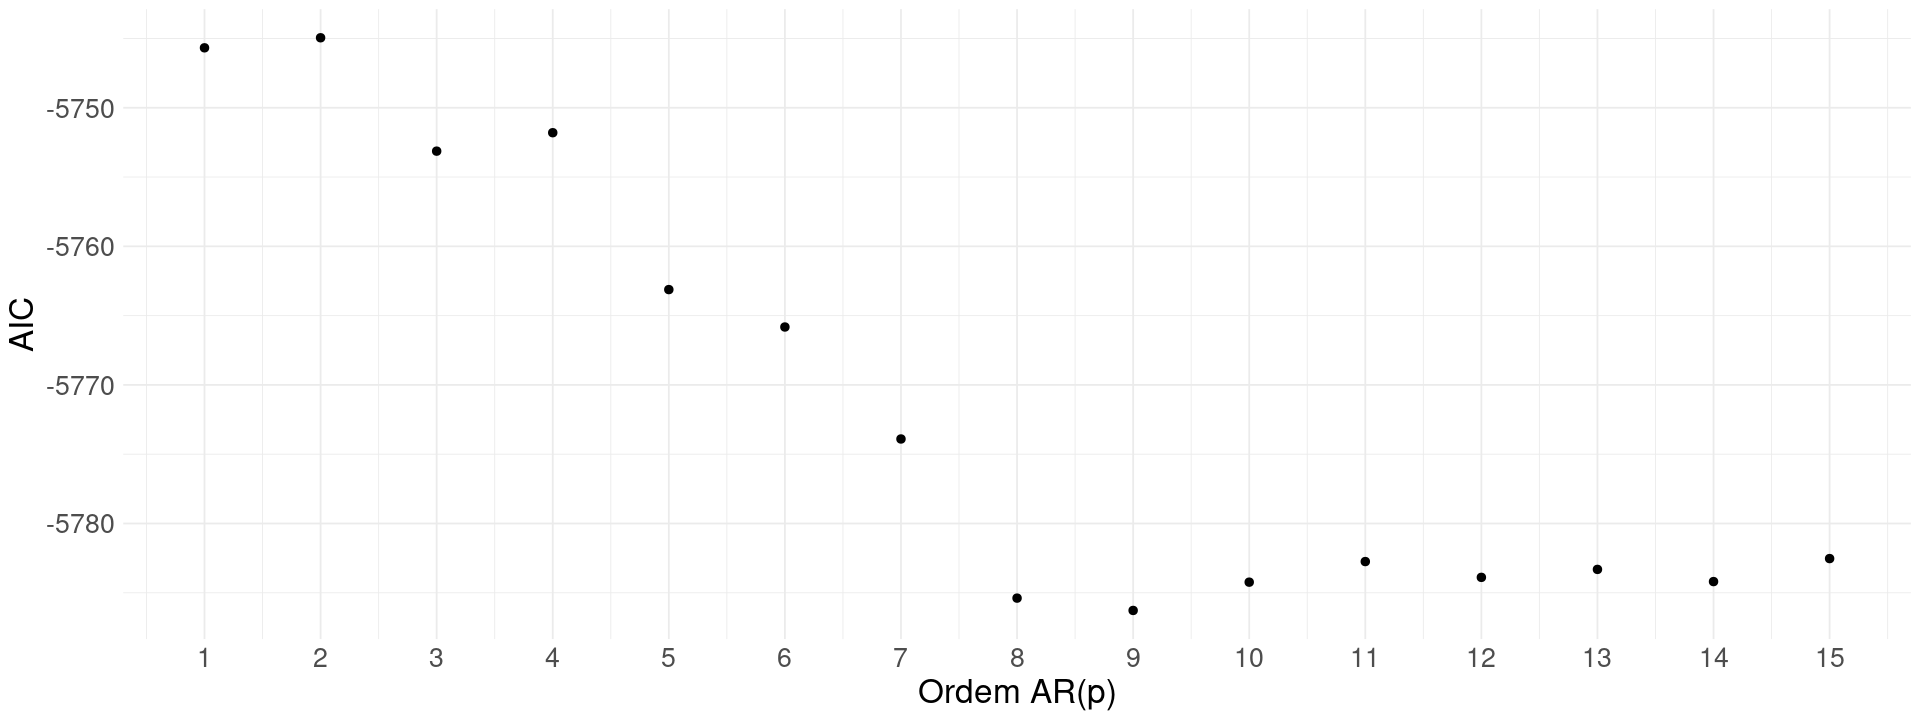

In [7]:
AIC <- c()
for(i in 1:15){
    k = i
    l = 0
    fit_arma <- arma(z, order = c(k,l))
    s <- summary(fit_arma)
    AIC[i] <- s$aic
    cat(paste0(
        "AIC de AR(", i, "): ",
        s$aic, " ou ", log(s$var) + 2*(k+l)/N, " (Akaike 1973-1974)", # Definição geral e definição proposta inicialmente por Akaike para os modelos ARMA
        "\n"
    ))
}

ggplot()+
    geom_point(aes(x = 1:15, y = AIC), size = 2)+
    scale_x_continuous(breaks = 1:15)+
    labs(x = "Ordem AR(p)")

Utilizando qualquer definição formalizada da quantidade AIC, vemos nestes casos, que o modelo que apresenta menor valor é de fato dado pela ordem 9 do modelo autorregressivo.

### Aplicação do modelo AR(9)

In [8]:
arma_fit <- Arima(z, order = c(9,0,0), fixed = c(NA,NA,NA,NA,NA,NA,NA,NA,NA,NA))
s <- summary(arma_fit)
s

Series: z 
ARIMA(9,0,0) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ar6     ar7     ar8
      0.0925  -0.0319  -0.0545  -0.0157  -0.0433  -0.0568  0.0310  0.0705
s.e.  0.0260   0.0261   0.0261   0.0261   0.0262   0.0262  0.0262  0.0263
         ar9    mean
      0.0452  0.0011
s.e.  0.0263  0.0009

sigma^2 = 0.001167:  log likelihood = 2890.46
AIC=-5758.93   AICc=-5758.75   BIC=-5700.68

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE       ACF1
Training set -3.47326e-05 0.03404913 0.02369948 NaN  Inf 0.7538321 -0.0001156

In [9]:
# Confidence intervals for all parameters

# Estimated standard deviation of all estimated parameters
sd_coef <- sqrt(diag(arma_fit$var.coef))

# Confidence level
alpha <- 0.05
zalpha <- qnorm(1-alpha/2)

names_coef <- names(arma_fit$coef)
for(i in 1:length(names_coef)){
    coef <- 

    lower <- arma_fit$coef[i] - zalpha * sd_coef[i]
    upper <- arma_fit$coef[i] + zalpha * sd_coef[i]
    
    cat(paste0(
        names_coef[i], " [",
        lower, ", ", upper,
        "]"
    ))
    if(!(lower < 0 & upper > 0))
        cat("*")
    cat("\n")
}


ar1 [0.0414685165169553, 0.143463832577719]*
ar2 [-0.0829496407258397, 0.0192425849084858]
ar3 [-0.10571545273479, -0.00336189288602727]*
ar4 [-0.066798330553601, 0.0354897397828527]
ar5 [-0.0945474279957972, 0.00797617876688417]
ar6 [-0.108056779035735, -0.00546888766773015]*
ar7 [-0.0204226325638289, 0.0824483103511893]
ar8 [0.019000889905101, 0.122067182372825]*
ar9 [-0.00622312681773855, 0.0967141666327766]
intercept [-0.000740725625441295, 0.00287030660877842]


De forma diferente do apresentado no livro (lembremos que não temos exatamente os mesmos dados que os utilizados no estudo original!), obtemos que os coeficientes significativos, a um nível de significância $\alpha = 0.05$ foram os coeficientes de ordens 1, 3, 6 e 8, respectivamente. Obtemos esses resultados a partir do intervalo de confiança estimado para cada parâmetro dado acima (caso o intervalo contenha o zero, não rejeitamos a hipótese nula de que o parâmetro seja igual a zero). Embora seja válido o reajuste do modelo considerando apenas essas ordens, prosseguimos diretamente com a análise dos resíduos através do modelo ARCH. Passemos a chamar nossa nova variável resposta de $u$.

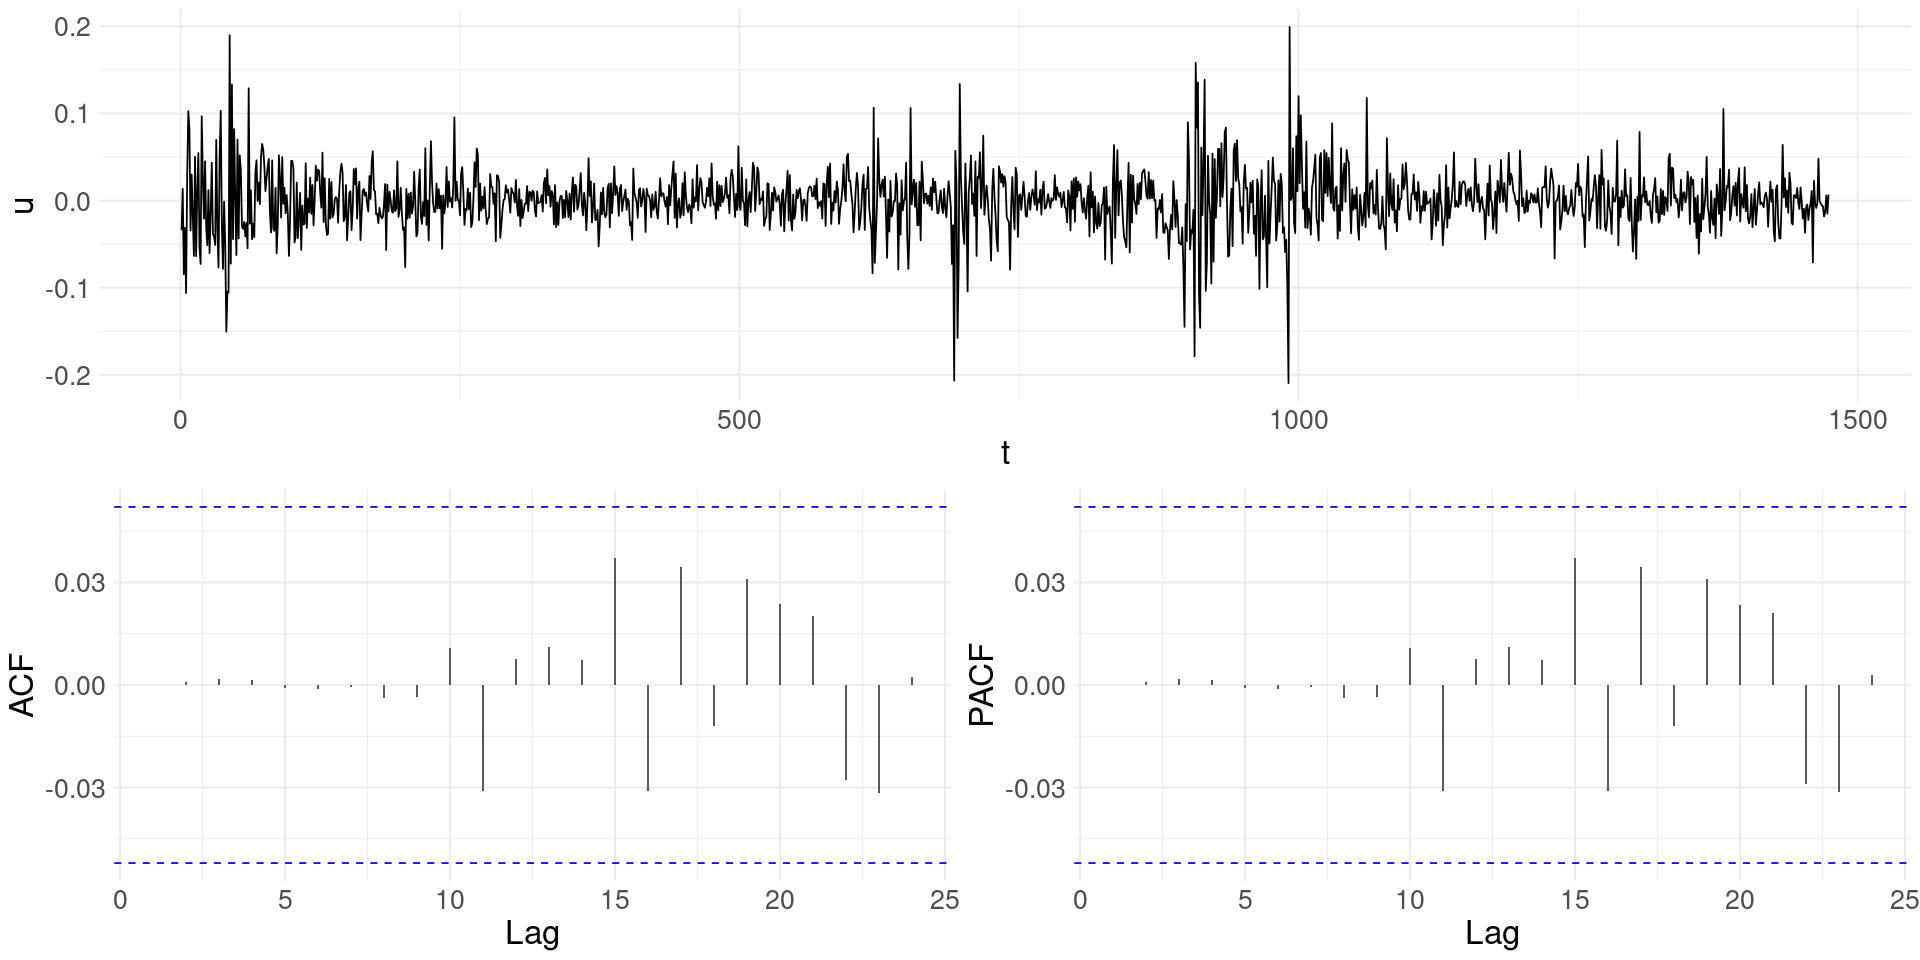

In [10]:
u <- c(arma_fit$residuals)

g1 <- ggplot()+
    geom_line(aes(x = t, y = u))

ACF_U <- acf(u, lag.max = 24, plot = FALSE)
PACF_U <- pacf(u, lag.max = 24, plot = FALSE)

g2 <- ggplot()+
    geom_col(aes(x = ACF_U$lag, y = ACF_U$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "ACF")

g3 <- ggplot()+
    geom_col(aes(x = PACF_U$lag, y = PACF_U$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "PACF")

options(repr.plot.width=16, repr.plot.height=8)
plot_grid(g1, plot_grid(g2, g3), nrow = 2)

Assim como queríamos, foi possível removermos toda a autocorrelação significativa da série de retornos. Façamos agora uma análise da volatilidade dos resíduos utilizando o modelo ARCH(p). Comecemos analisando a autocorrelação e autocorrelação parcial do quadrado dos resíduos.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


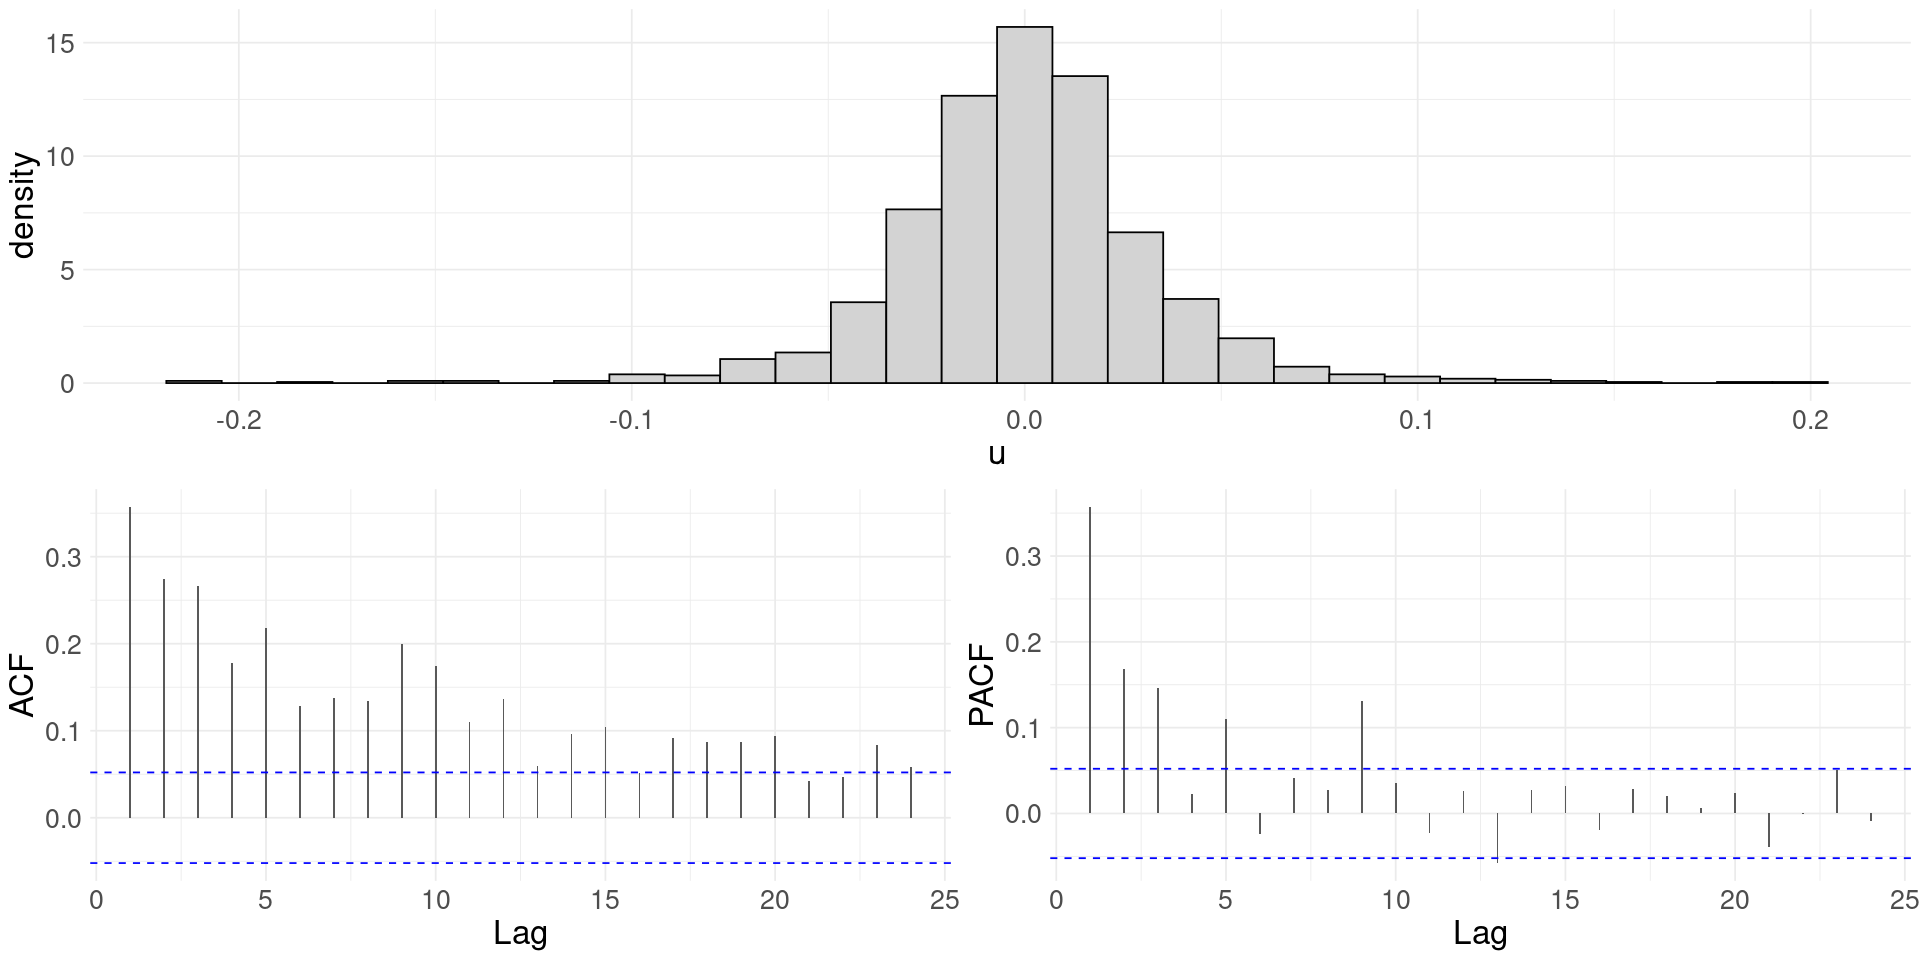

In [11]:
u2 <- u^2

ACF_U2 <- acf(u2, lag.max = 24, plot = FALSE)
PACF_U2 <- pacf(u2, lag.max = 24, plot = FALSE)

g1 <- ggplot()+
    geom_col(aes(x = ACF_U2$lag, y = ACF_U2$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "ACF")

g2 <- ggplot()+
    geom_col(aes(x = PACF_U2$lag, y = PACF_U2$acf), width = 0.05)+
    geom_hline(aes(yintercept = 2/sqrt(N)), linetype = "dashed", color = "blue")+
    geom_hline(aes(yintercept = -2/sqrt(N)), linetype = "dashed", color = "blue")+
    labs(x = "Lag", y = "PACF")

g3 <- ggplot()+
    geom_histogram(aes(x = u, y = ..density..), color = "black", fill = "lightgray", bins = 30)

options(repr.plot.width=16, repr.plot.height=8)
plot_grid( g3, plot_grid(g1, g2), nrow = 2)

A partir do gráfico da autocorrelação parcial, vejamos o ajuste do modelo ARCH(3), como sugerido por Morettin (2006). Entretanto, fica evidente que temos indícios de que o modelo ARCH(9) seja adequado para a modelagem. Após a primeira aplicação (ARCH(3)), façamos uma comparação dos modelos usando o critério AIC.

Naturalmente, embora já tenhamos ajustado um modelo ARMA(9,0) = AR(9) aos valores dos log-retornos, é de preferência que seja realizado o ajuste conjunto do modelo ARCH, estimando tanto os parâmetros do ARMA quanto do GARCH simultaneamente. Note que quando aplicamos a abordagem sequencial, no primeiro estágio (model ARMA) assumimos que a variância é constante (ARMA assume estacionariedade), o que não é verdade pela a hipótese de heteroscedasticidade. Dessa maneira, é mais adequada a otimização dos parâmetros considerando um modelo misto ARMA-GARCH para o estudo.

In [12]:
r <- 9 # Componente ARCH
s <- 0 # Componente GARCH

# Specifications for the GARCH model
garch_spec <- ugarchspec(
    variance.model = list(model = "sGARCH", garchOrder = c(r, s)),
    mean.model = list(armaOrder = c(9,0), include.mean = FALSE),
    distribution.model = "norm",
    # fixed.pars = list(ar2 = 0, ar4 = 0, ar5 = 0, ar6 = 0, ar7 = 0, ar8 = 0) # O livro supoe esse resultado a partir da modelagem ARMA individual, o que pode não ser adequado dada a modelagem conjunta...
)

garch_fit <- ugarch_fit <- ugarchfit(spec = garch_spec, data = u)
garch_fit@fit$coef

ar1           ar2           ar3           ar4           ar5 
 2.679322e-04  2.048615e-02  1.966630e-02  1.979311e-02 -5.636767e-03 
          ar6           ar7           ar8           ar9         omega 
 2.592374e-02  2.405416e-03 -6.003860e-02 -6.212266e-02  2.479560e-04 
       alpha1        alpha2        alpha3        alpha4        alpha5 
 1.804975e-01  1.945211e-01  1.452026e-01  6.598155e-12  4.720723e-02 
       alpha6        alpha7        alpha8        alpha9 
 1.670229e-02  1.401903e-01  8.761384e-03  5.205904e-02

A partir dos coeficientes estimados, podemos obter quais os pontos na série observada que obtiveram maiores valores para a volatilidade dos preços. Podemos ver alguns picos de interesse no gráfico abaixo e comparar com o comportamento dos retornos. De fato, percebe-se um padrão claro de aumento da volatilidade nos períodos de maior variação da série de retornos.

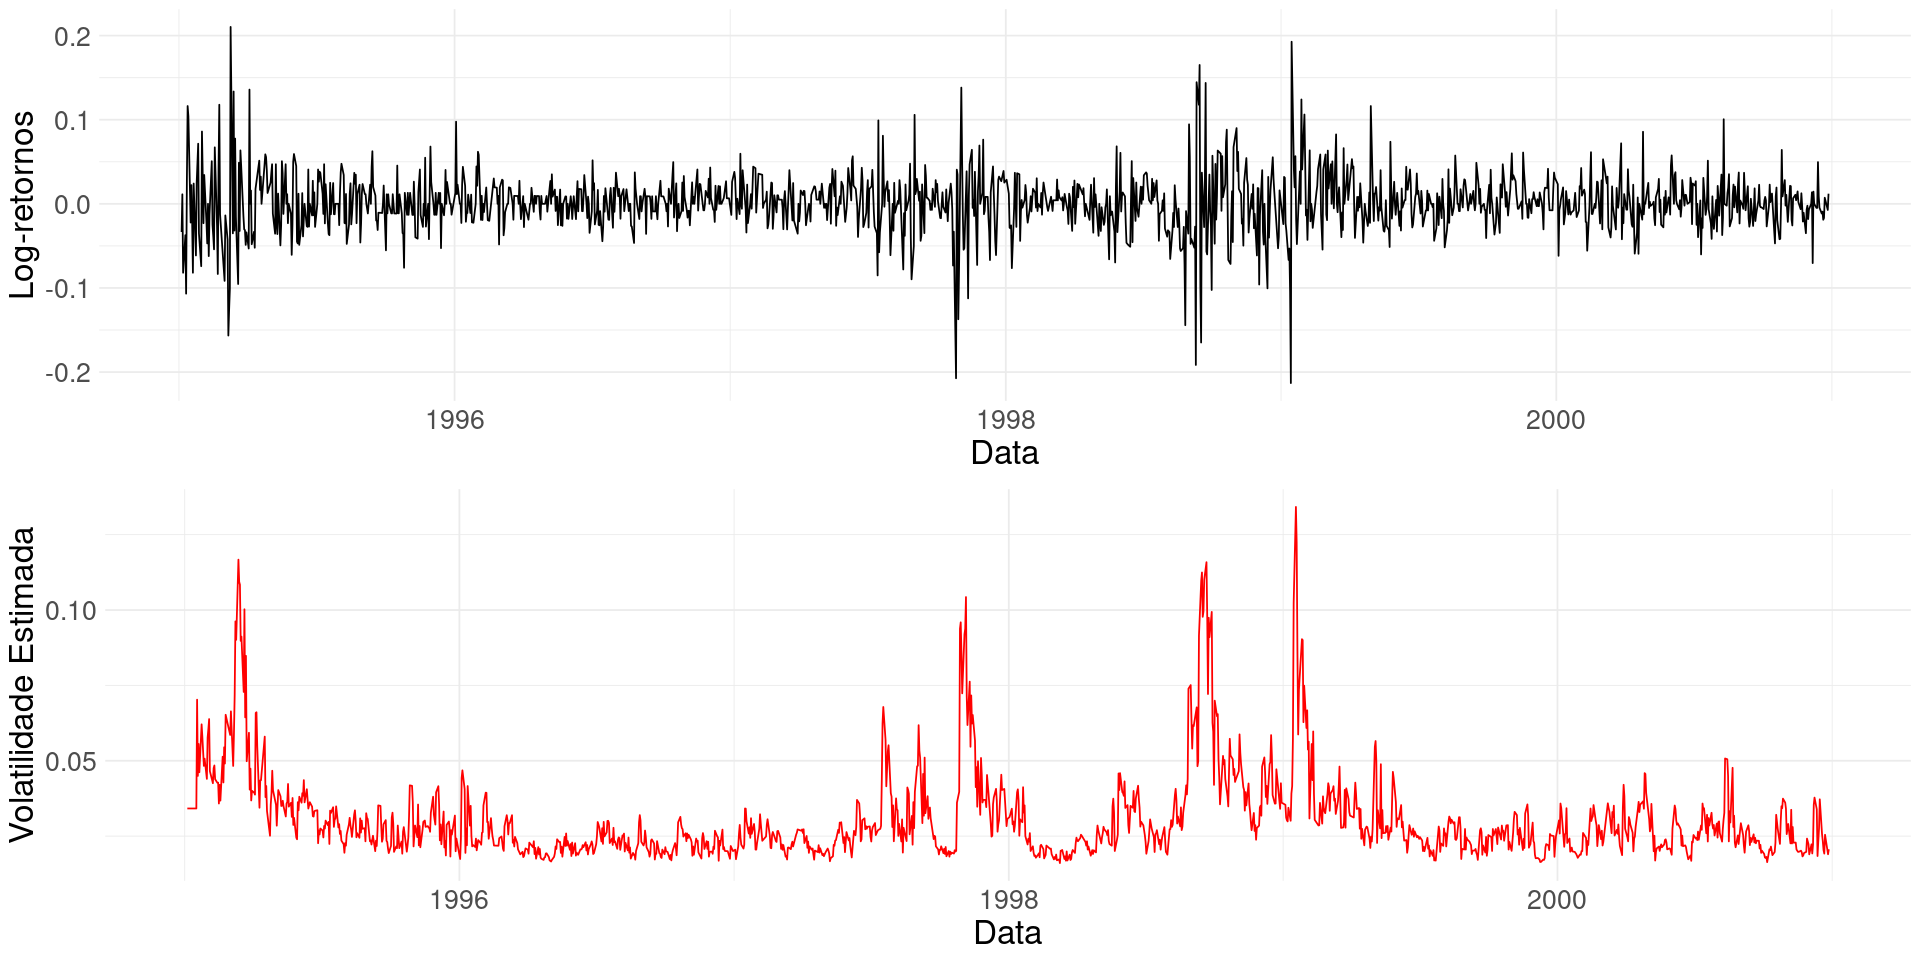

In [13]:
g1 <- ggplot()+
    geom_line(aes(x = df$date[-1], y = z), color = "black")+
    labs(x = "Data", y = "Log-retornos")

g2 <- ggplot()+
    geom_line(aes(x = df$date[-1], y = garch_fit@fit$sigma), color = "red")+
    labs(x = "Data", y = "Volatilidade Estimada")

plot_grid(g1, g2, nrow = 2)

De fato os pontos de maior volatilidade da série representam períodos de crise que, consequentemente, impactaram as ações da Petrobrás. Como argumentado por Morettin (2006), alguns desses períodos são:
* Março de 1995: Crise do México;
* Setembro de 1996: Moratória da Rússia;
* Outubro de 1997: Final da crise da Ásia;
* Janeiro de 1999: Desvalorização do Real;
Destacamos tais acontecimentos no seguinte gráfico.

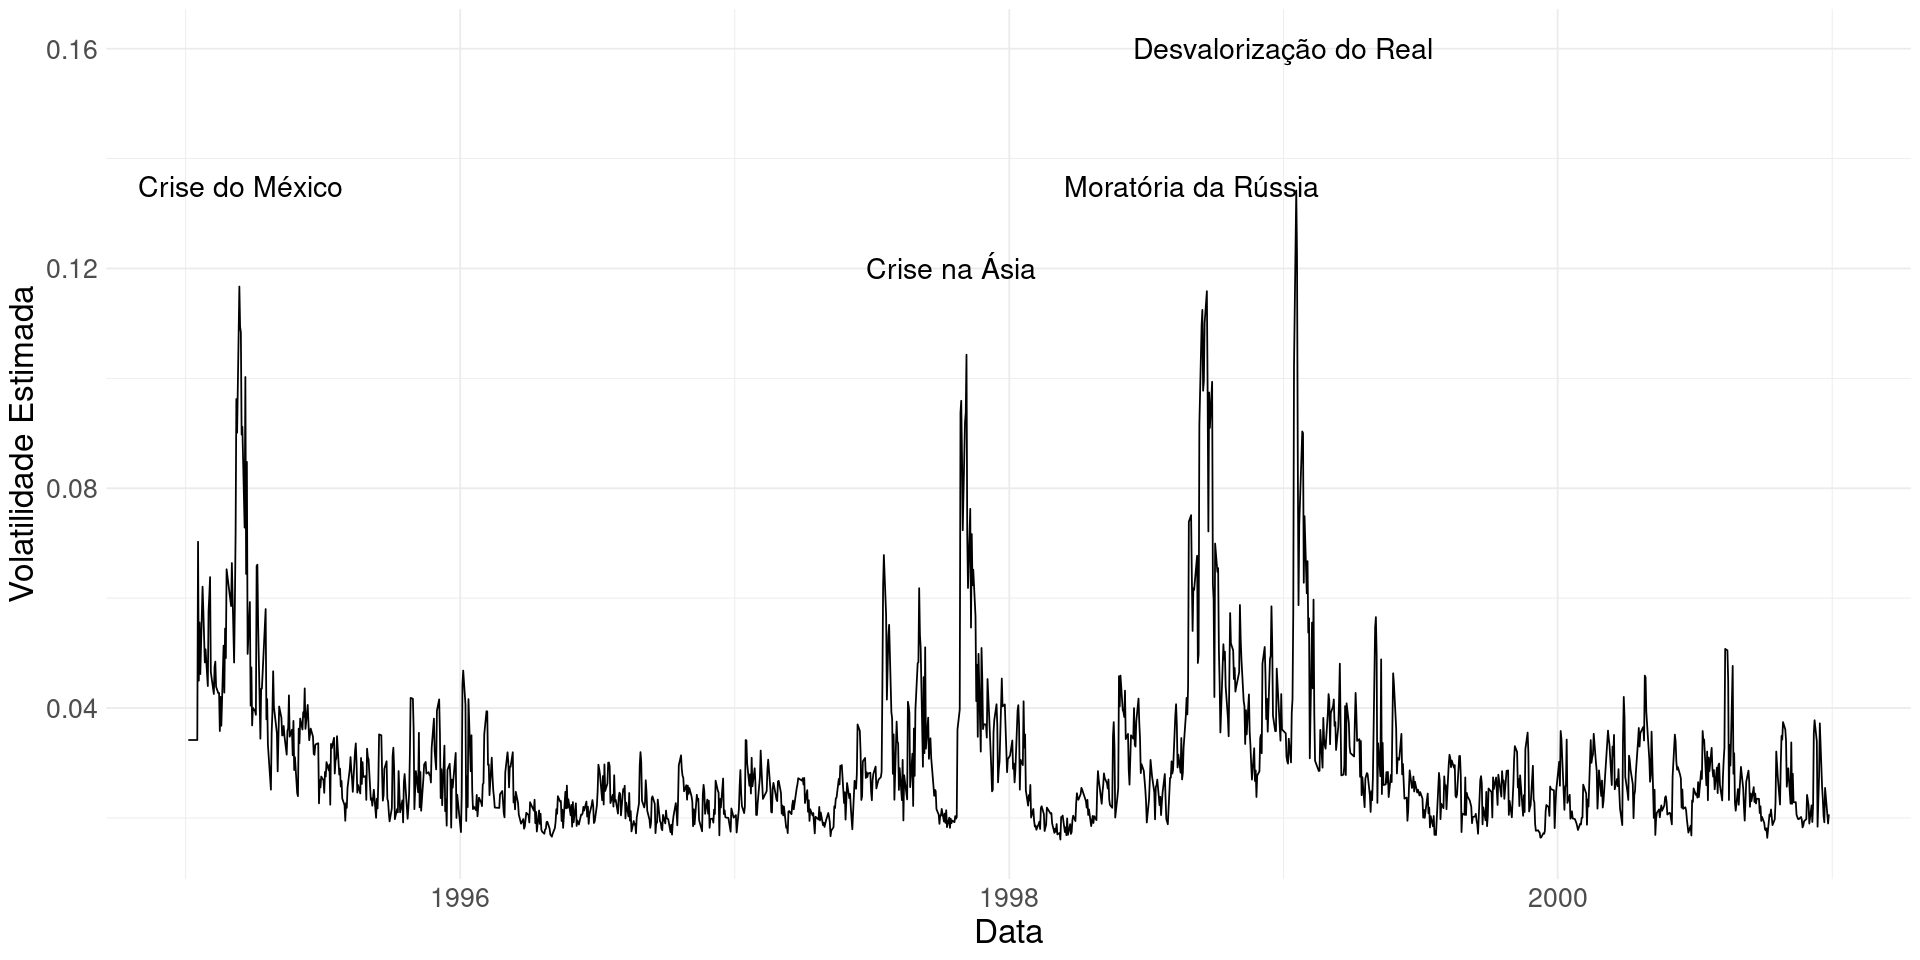

In [14]:
ggplot()+
    geom_line(aes(x = df$date[-1], y = garch_fit@fit$sigma ))+
    geom_text(aes(x = as.Date(c("1995-03-15", "1997-10-15", "1998-09-1", "1999-01-01")), y = c(0.135,0.12,0.135,0.16), label = c("Crise do México", "Crise na Ásia", "Moratória da Rússia", "Desvalorização do Real") ), size = 6)+
    labs(x = "Data", y = "Volatilidade Estimada")

Finalmente, vejamos se o quadrado dos resíduos padronizados do modelo ARCH de fato são não correlacionados entre si. Para verificarmos isso, basta realizarmos o teste de Ljung-Box nos valores desses resíduos.

In [15]:
std_residuals <- garch_fit@fit$residuals/garch_fit@fit$sigma

Box.test( std_residuals^2, lag = 25, type = "Ljung-Box" )


	Box-Ljung test

data:  std_residuals^2
X-squared = 24.063, df = 25, p-value = 0.5157


Tomando o teste para lags de 1 a 25, percebe-se claramente que o teste não rejeita a hipótese nula de que os quadrados dos resíduos são não correlacionados. Concluímos, assim que o modelo se ajustou bem aos dados, sendo capaz de explicar consideravelmente tanto a média quanto a variabilidade da série.